In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/dataset.zip','r')
zip_ref.extractall()
zip_ref.close()

In [4]:
import os
import shutil

def rename_folders(base_dir):
    # Loop through crops (Cashew, Cassava, Maize, Tomato) directly within the base_dir
    for crop in os.listdir(base_dir):
        crop_path = os.path.join(base_dir, crop)
        if not os.path.isdir(crop_path):
            continue

        # Loop through disease/health subfolders
        for condition in os.listdir(crop_path):
            old_path = os.path.join(crop_path, condition)
            if not os.path.isdir(old_path):
                continue

            # New folder name (Cashew_Healthy etc.)
            new_folder_name = f"{crop}_{condition}"
            new_path = os.path.join(base_dir, new_folder_name) # Create new folder in the base_dir

            # Move the folder contents
            if os.path.exists(new_path):
                # Merge if already exists
                for file in os.listdir(old_path):
                    shutil.move(os.path.join(old_path, file), new_path)
                os.rmdir(old_path)
            else:
                shutil.move(old_path, new_path)

        # Remove empty crop folder (e.g., "Cashew")
        if not os.listdir(crop_path):
            os.rmdir(crop_path)


# Example usage
base_dir = "/content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset" # Corrected base directory
rename_folders(base_dir)
print("✅ Dataset folders renamed successfully!")

✅ Dataset folders renamed successfully!


In [5]:
import os
import shutil
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFile   # 👈 add this
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# 👇 add this line here
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [6]:
IMAGE_SIZE = 224
PATCH_SIZE = 16

In [7]:
# Verify Images Function
def verify_images(directory):
    broken_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()
            except Exception as e:
                print(f" Corrupted image: {file_path} | Error: {e}")
                broken_images.append(file_path)
    return broken_images

In [8]:
# Train/Validation Split (fixed to stay inside dataset folder)
def split_dataset(base_dir, val_ratio=0.15):
    val_base_dir = os.path.join(base_dir, "Validation")

    classes = os.listdir(base_dir)
    for cls in classes:
        cls_path = os.path.join(base_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        if cls == "Validation":  # skip if Validation already exists
            continue

        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if len(images) == 0:
            print(f"⚠ No images found in {cls_path}")
            continue

        train_imgs, val_imgs = train_test_split(images, test_size=val_ratio, random_state=42)

        # Create validation dir for this class
        val_dir = os.path.join(val_base_dir, cls)
        os.makedirs(val_dir, exist_ok=True)

        # Move validation images
        for img in val_imgs:
            shutil.move(os.path.join(cls_path, img), os.path.join(val_dir, img))

        print(f"✅ Moved {len(val_imgs)} images to {val_dir}")

In [10]:
mean_vals = [0.485, 0.456, 0.406]
std_vals = [0.229, 0.224, 0.225]

In [11]:
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals, std=std_vals)
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals, std=std_vals)
])

In [12]:
   # Load Dataset
def load_datasets(train_path, val_path):
    train_dataset = datasets.ImageFolder(train_path, transform=train_transforms)
    val_dataset = datasets.ImageFolder(val_path, transform=val_transforms)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
    return train_loader, val_loader, train_dataset.classes

In [13]:
# Convert Image Batch to ViT Patches
def image_to_patches(img_batch, patch_size):
    B, C, H, W = img_batch.shape  # Batch Size, Channels, Height, Width
    patches = img_batch.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous().view(B, -1, C * patch_size * patch_size)
    return patches  # Shape: (Batch, Num_Patches, Flattened Patch Size)

In [14]:
# Display Sample Images with Patches
def imshow_batch(loader, classes):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    def unnormalize(img):
        std_tensor = torch.tensor(std_vals).view(3, 1, 1)
        mean_tensor = torch.tensor(mean_vals).view(3, 1, 1)
        img = img * std_tensor + mean_tensor  # Reverse normalization
        return img.clamp(0, 1)  # Clip values between 0-1

    fig, axes = plt.subplots(1, 8, figsize=(20, 3))
    for i in range(8):
        img = unnormalize(images[i]).permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    plt.show()
# Convert to Patches for ViT
    patches = image_to_patches(images, PATCH_SIZE)
    print(f"Patches Shape: {patches.shape}")  # (Batch, Num_Patches, Flattened Patch Size)

# Run Pipeline
dataset_path = "/content/Dataset for Crop Pest and Disease Detection"
train_path = os.path.join(dataset_path, "Train")
val_path = os.path.join(dataset_path, "Test")

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm # Import timm here

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image preprocessing
image_size = 224
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Dataset paths
dataset_root = "/content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset"
# Assuming the dataset is structured with subfolders for each class

train_dataset = datasets.ImageFolder(dataset_root, transform=transform)
test_dataset = datasets.ImageFolder(dataset_root, transform=transform) # Using the same dataset for simplicity in this example

class_names = train_dataset.classes
print("Class Labels:", class_names)

num_classes = len(train_dataset.classes)

# Load pretrained ViT
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=num_classes)
model.to(device)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Class Labels: ['Cashew_anthracnose', 'Cashew_gumosis', 'Cashew_healthy', 'Cashew_leaf miner', 'Cashew_red rust', 'Cassava_bacterial blight', 'Cassava_brown spot', 'Cassava_green mite', 'Cassava_healthy', 'Cassava_mosaic', 'Maize_fall armyworm', 'Maize_grasshoper', 'Maize_healthy', 'Maize_leaf beetle', 'Maize_leaf blight', 'Maize_leaf spot', 'Maize_streak virus', 'Tomato_healthy', 'Tomato_leaf blight', 'Tomato_leaf curl', 'Tomato_septoria leaf spot', 'Tomato_verticulium wilt']


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [16]:
# Clean dataset from corrupt images
corrupt_files = verify_images(dataset_path)
if corrupt_files:
    print(f"⚠ Found {len(corrupt_files)} corrupt images. Removing them...")
    for f in corrupt_files:
        try:
            os.remove(f)
            print(f"Removed: {f}")
        except Exception as e:
            print(f"Error removing {f}: {e}")
else:
    print("✅ No corrupt images found!")

# Rebuild datasets and loaders after cleanup
full_dataset = datasets.ImageFolder(dataset_path, transform=train_transforms)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

print("✅ Dataloaders rebuilt successfully")

 Corrupted image: /content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Tomato_leaf blight/leaf blight645_.jpg | Error: cannot identify image file '/content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Tomato_leaf blight/leaf blight645_.jpg'
 Corrupted image: /content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Tomato_leaf blight/leaf blight72_.jpg | Error: cannot identify image file '/content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Tomato_leaf blight/leaf blight72_.jpg'
 Corrupted image: /content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Tomato_leaf blight/leaf blight1232_.jpg | Error: cannot identify image file '/content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Tomato_leaf blight/leaf blight1232_.jpg'
 Corrupted image: /content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Tomato_leaf blight/leaf blight998_.jpg | Error: cannot 

Verifying images...
All images verified successfully.
Classes: ['Cashew_anthracnose', 'Cashew_gumosis', 'Cashew_healthy', 'Cashew_leaf miner', 'Cashew_red rust', 'Cassava_bacterial blight', 'Cassava_brown spot', 'Cassava_green mite', 'Cassava_healthy', 'Cassava_mosaic', 'Maize_fall armyworm', 'Maize_grasshoper', 'Maize_healthy', 'Maize_leaf beetle', 'Maize_leaf blight', 'Maize_leaf spot', 'Maize_streak virus', 'Tomato_healthy', 'Tomato_leaf blight', 'Tomato_leaf curl', 'Tomato_septoria leaf spot', 'Tomato_verticulium wilt']


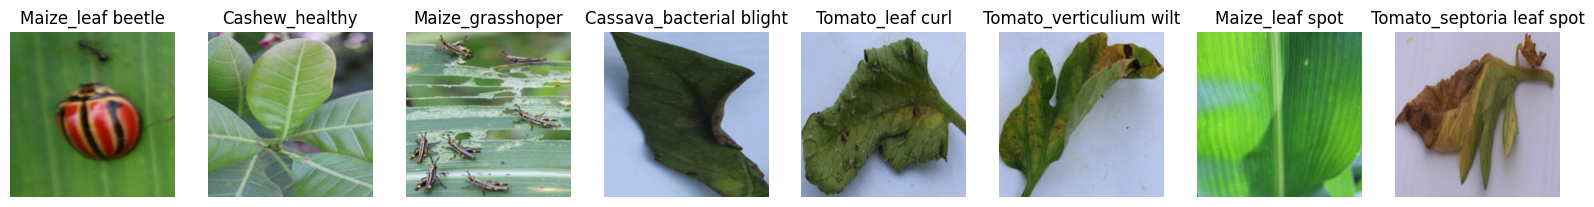

Patches Shape: torch.Size([8, 196, 768])


In [17]:
# Define paths
dataset_path = "/content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset"

# Verify images before processing
print("Verifying images...")
broken_images = verify_images(dataset_path)
if broken_images:
    print(f"Found {len(broken_images)} broken images. Consider removing them.")
    # Optionally add code here to remove or quarantine broken_images
else:
    print("All images verified successfully.")

# Train/Validation split handled automatically by torch.utils.data.random_split
full_dataset = datasets.ImageFolder(dataset_path, transform=train_transforms)

# 80/20 split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

class_names = full_dataset.classes
print("Classes:", class_names)

# Show a sample batch
imshow_batch(train_loader, class_names)

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm
from PIL import Image
import matplotlib.pyplot as plt

In [19]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image preprocessing
image_size = 224
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Dataset paths
dataset_root = "/content/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset" # Define dataset_root
train_dir = dataset_root  # Use the correct path
test_dir = dataset_root   # Use the correct path

# Function to check if a file is a valid image
def is_valid_image(path):
    return os.path.isfile(path) and path.lower().endswith(('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp'))

train_dataset = datasets.ImageFolder(train_dir, transform=transform, is_valid_file=is_valid_image)
test_dataset = datasets.ImageFolder(test_dir, transform=transform, is_valid_file=is_valid_image)


# Extract class names from the dataset structure
class_names = train_dataset.classes
print("Class Labels:", class_names)

num_classes = len(train_dataset.classes)

Class Labels: ['Cashew_anthracnose', 'Cashew_gumosis', 'Cashew_healthy', 'Cashew_leaf miner', 'Cashew_red rust', 'Cassava_bacterial blight', 'Cassava_brown spot', 'Cassava_green mite', 'Cassava_healthy', 'Cassava_mosaic', 'Maize_fall armyworm', 'Maize_grasshoper', 'Maize_healthy', 'Maize_leaf beetle', 'Maize_leaf blight', 'Maize_leaf spot', 'Maize_streak virus', 'Tomato_healthy', 'Tomato_leaf blight', 'Tomato_leaf curl', 'Tomato_septoria leaf spot', 'Tomato_verticulium wilt']


In [20]:
# Load pretrained ViT
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=num_classes)
model.to(device)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [21]:
def train_model(model, train_loader, epochs=1):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")


In [22]:
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")
train_model(model, train_loader, epochs=1)
evaluate_model(model, test_loader)

Epoch [1/1], Loss: 0.5816
Test Accuracy: 87.66%


The model has been trained and evaluated. The next step could be to use the trained model to predict on new images.

Enter leaf image paths (comma separated): /OIP (1).webp,/OIP (2).webp,/OIP (3).webp,/OIP.webp,/algal-leaf-spot-cashew-viet-nam-injure-187096524.webp,/maize-green-leaf-plant-flower-corn-pure-nature-close-up-cloud-blue-sky-nepal-maize-green-leaf-plant-flower-corn-176759258.webp,/3945716612_8b1f418762_b.jpg,/D869_27_632_1200.jpg,/stock-photo-cassava-leaves-green-cassava-leaves-cassava-leaves-background-cassava-leaves-plant-or-daun-2271199389.jpg

Image 1: Maize leaf is Not Healthy ❌ (Disease: streak virus)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


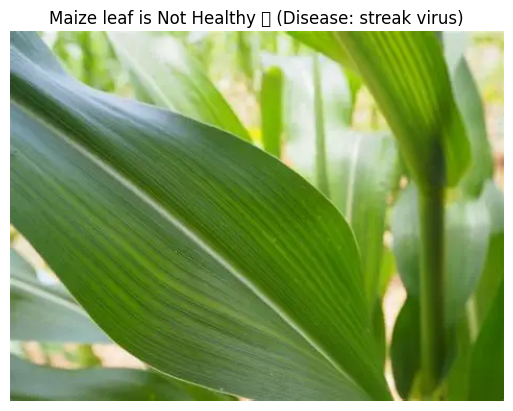


Image 2: Tomato leaf is Healthy ✅


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


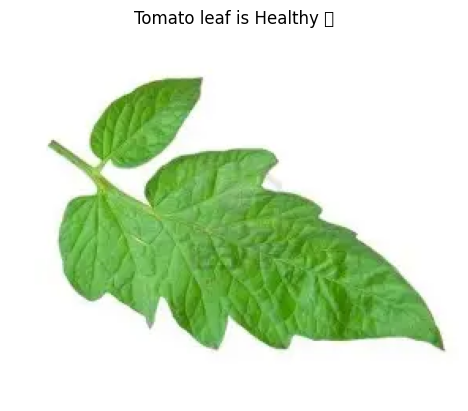


Image 3: Tomato leaf is Not Healthy ❌ (Disease: leaf curl)


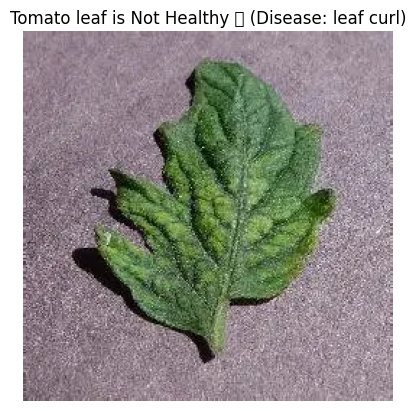


Image 4: Cashew leaf is Healthy ✅


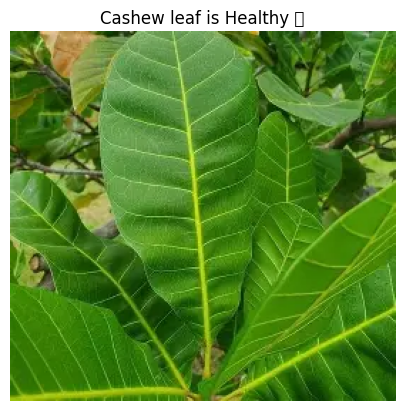


Image 5: Cashew leaf is Not Healthy ❌ (Disease: leaf miner)


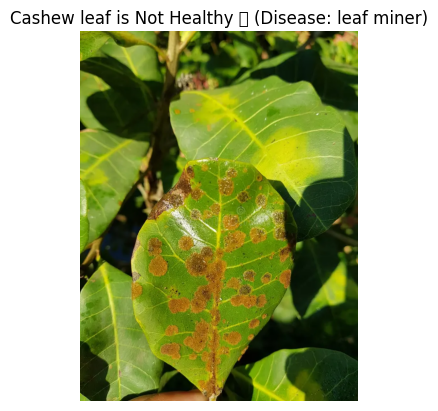


Image 6: Maize leaf is Not Healthy ❌ (Disease: streak virus)


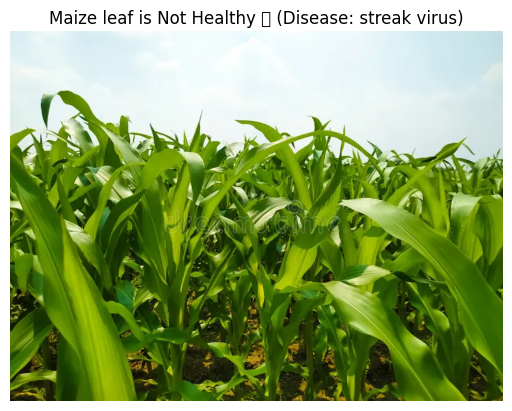


Image 7: Cassava leaf is Not Healthy ❌ (Disease: green mite)


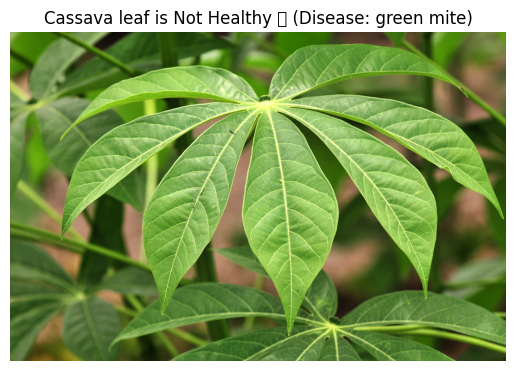


Image 8: Tomato leaf is Healthy ✅


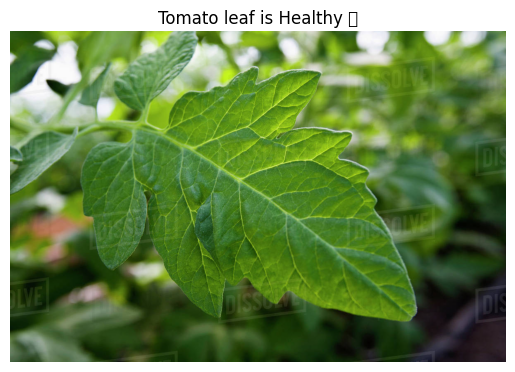


Image 9: Cassava leaf is Not Healthy ❌ (Disease: green mite)


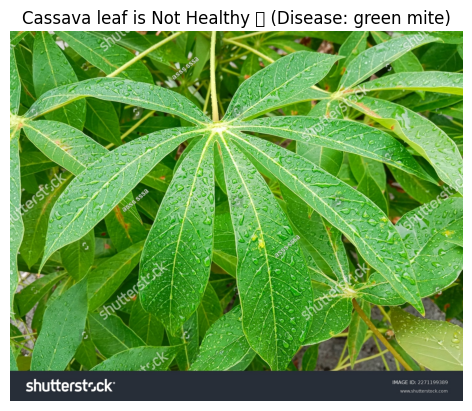

In [27]:
def predict_leaf(image_path):
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)

    pred_class = class_names[predicted.item()]
    # Example: "Cashew_RedRust"

    # Split crop & condition
    if "_" in pred_class:
        crop, condition = pred_class.split("_", 1)
    else:
        crop, condition = pred_class, "Unknown"

    if condition.lower() == "healthy":
        return f"{crop} leaf is Healthy ✅", img
    else:
        return f"{crop} leaf is Not Healthy ❌ (Disease: {condition})", img
def main():
    image_paths = input("Enter leaf image paths (comma separated): ")
    if not image_paths:
        print("Please provide valid image paths.")
        return

    for idx, path in enumerate(image_paths.split(",")):
        prediction, img = predict_leaf(path.strip())
        print(f"\nImage {idx+1}: {prediction}")

        plt.imshow(img)
        plt.title(prediction)
        plt.axis("off")
        plt.show()

if __name__ == "__main__":
    main()


Enter leaf image paths (comma separated): /OIP (4).webp

Image 1: Cassava leaf is Healthy ✅


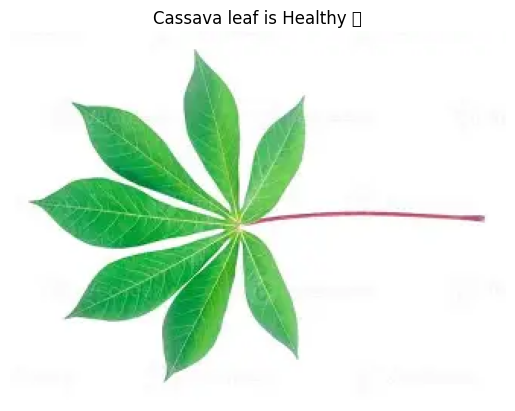

In [28]:
def predict_leaf(image_path):
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)

    pred_class = class_names[predicted.item()]
    # Example: "Cashew_RedRust"

    # Split crop & condition
    if "_" in pred_class:
        crop, condition = pred_class.split("_", 1)
    else:
        crop, condition = pred_class, "Unknown"

    if condition.lower() == "healthy":
        return f"{crop} leaf is Healthy ✅", img
    else:
        return f"{crop} leaf is Not Healthy ❌ (Disease: {condition})", img
def main():
    image_paths = input("Enter leaf image paths (comma separated): ")
    if not image_paths:
        print("Please provide valid image paths.")
        return

    for idx, path in enumerate(image_paths.split(",")):
        prediction, img = predict_leaf(path.strip())
        print(f"\nImage {idx+1}: {prediction}")

        plt.imshow(img)
        plt.title(prediction)
        plt.axis("off")
        plt.show()

if __name__ == "__main__":
    main()


Now you can use the `predict_leaf` function with the path to an image to get a prediction. For example: